# 数据探索

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
sns.set_theme(style="whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


In [3]:
path='../data/train.csv'
train_data=pd.read_csv(path,parse_dates=['Date'])
print("序列长度为：",len(train_data))
train_data.head()

/tmp/ipykernel_1685/3439670201.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data=pd.read_csv(path,parse_dates=['Date'])


序列长度为： 1017209


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


我们发现有多个不同店铺，按店铺不同商品的数据，因此需要group操作

In [4]:
set1=set(train_data['Store'])
print("店铺数量：",len(set1))

店铺数量： 1115


我们将用店铺1的时序特征来分析

In [5]:
store1=train_data[train_data['Store']==1]
store1.sort_values(by='Date',ascending=True,inplace=True)
store1=store1.set_index('Date').asfreq('D')
print('商店1的序列长度为：',len(store1))
store1.head()

商店1的序列长度为： 942


/tmp/ipykernel_1685/1499647798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1.sort_values(by='Date',ascending=True,inplace=True)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [6]:
store1.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-27,1,1,6102,612,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-31,1,5,5263,555,1,1,0,1


考察Sales和Customers的相关性

In [31]:
print("相关系数为",train_data['Sales'].corr(train_data['Customers']))

相关系数为 0.8947107733017032


两者呈现出非常强烈的相关性，这说明顾客人数是很重要的销售额影响因子

###  对商店1sales的趋势分析

<Axes: xlabel='time_dummy', ylabel='Sales'>

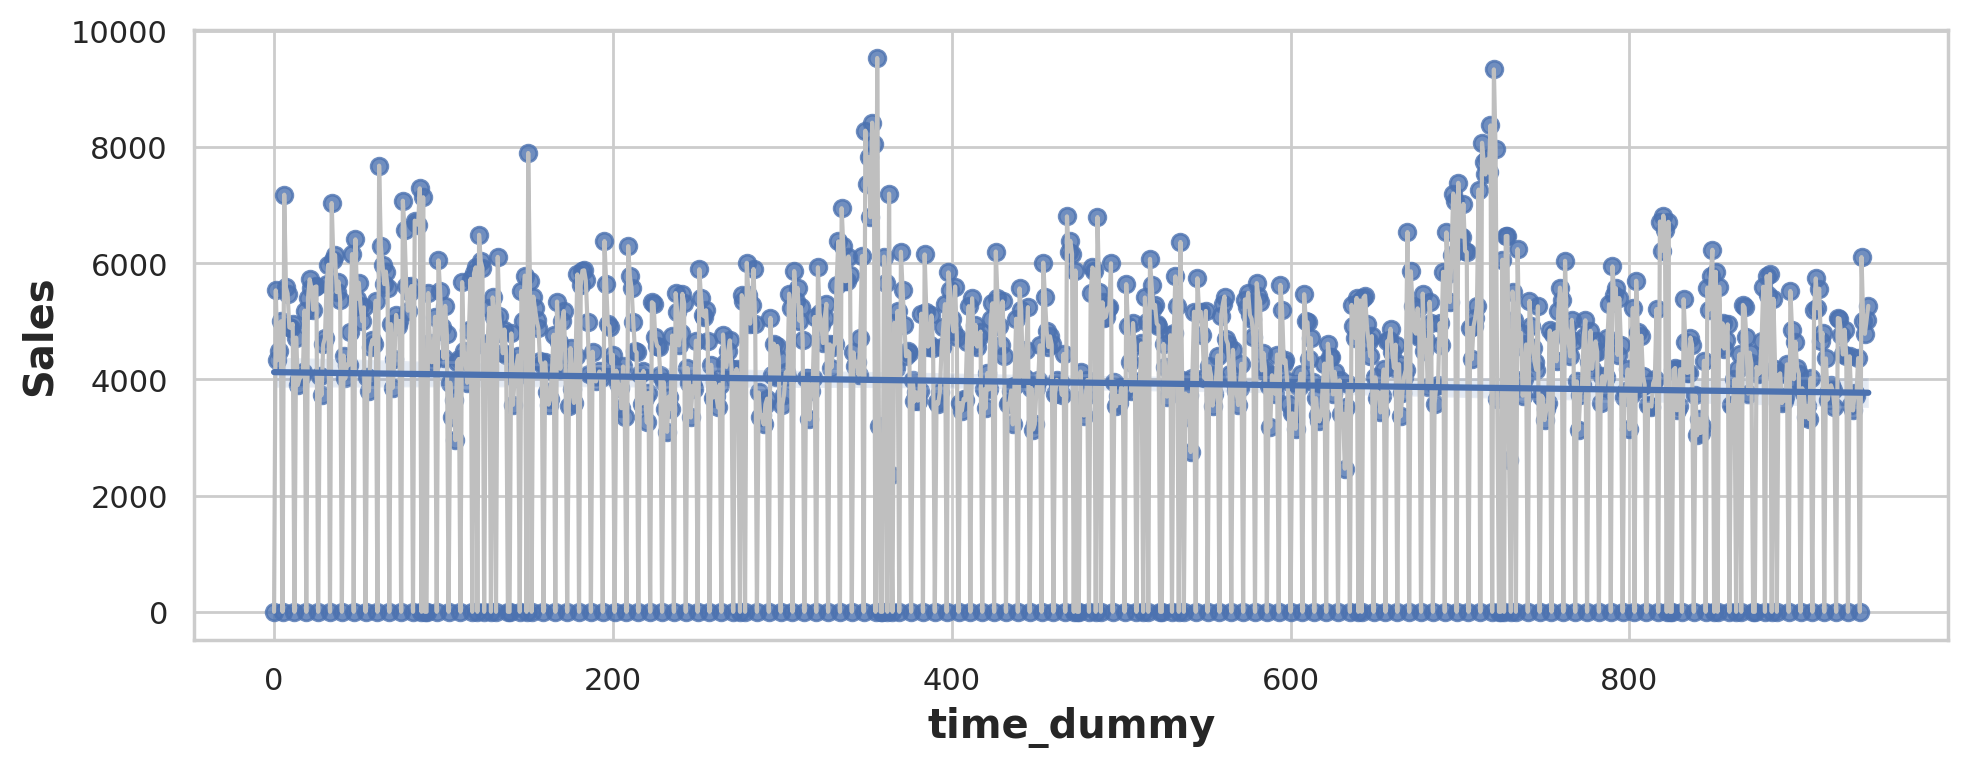

In [7]:
store1['time_dummy']=np.arange(len(store1))
ig, ax = plt.subplots(figsize=(10, 4))
ax.plot('time_dummy','Sales',data=store1,color='0.75')
sns.regplot(x='time_dummy',y='Sales',data=store1,ax=ax)

可以发现销售量随天数变化呈现出强周期性，并且趋势平稳。且存在一些销售量为0的异常点，可能是由于节假日。我们用rolling_mean来平滑一下

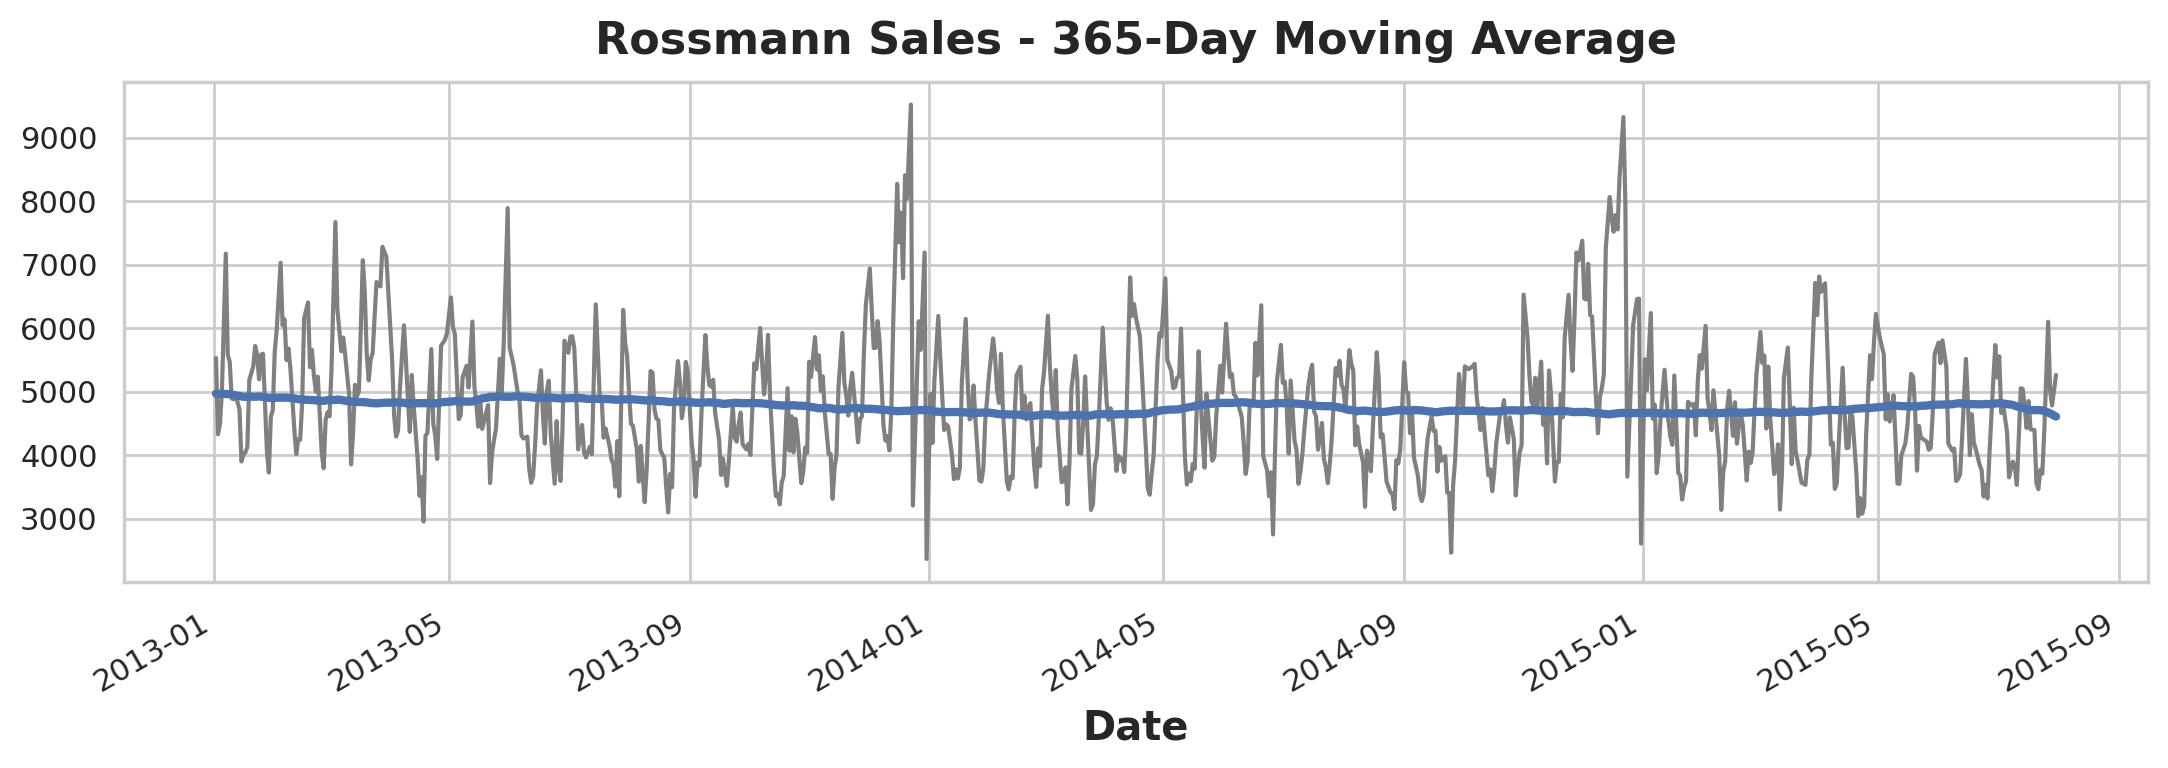

In [8]:
move_average=store1[store1['Sales']!=0]['Sales'].rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax=store1[store1['Sales']!=0]['Sales'].plot(color='0.5')
move_average.plot(ax=ax, linewidth=3, title="Rossmann Sales - 365-Day Moving Average", legend=False,);


我们将sales不为0的部分拿出来做rolling meanean，可以看到趋势平稳，周期性明显。由于高度平稳的趋势，我考虑直接使用gbdt

### 对store1的customer趋势分析

我们用相同方法分析customer的趋势

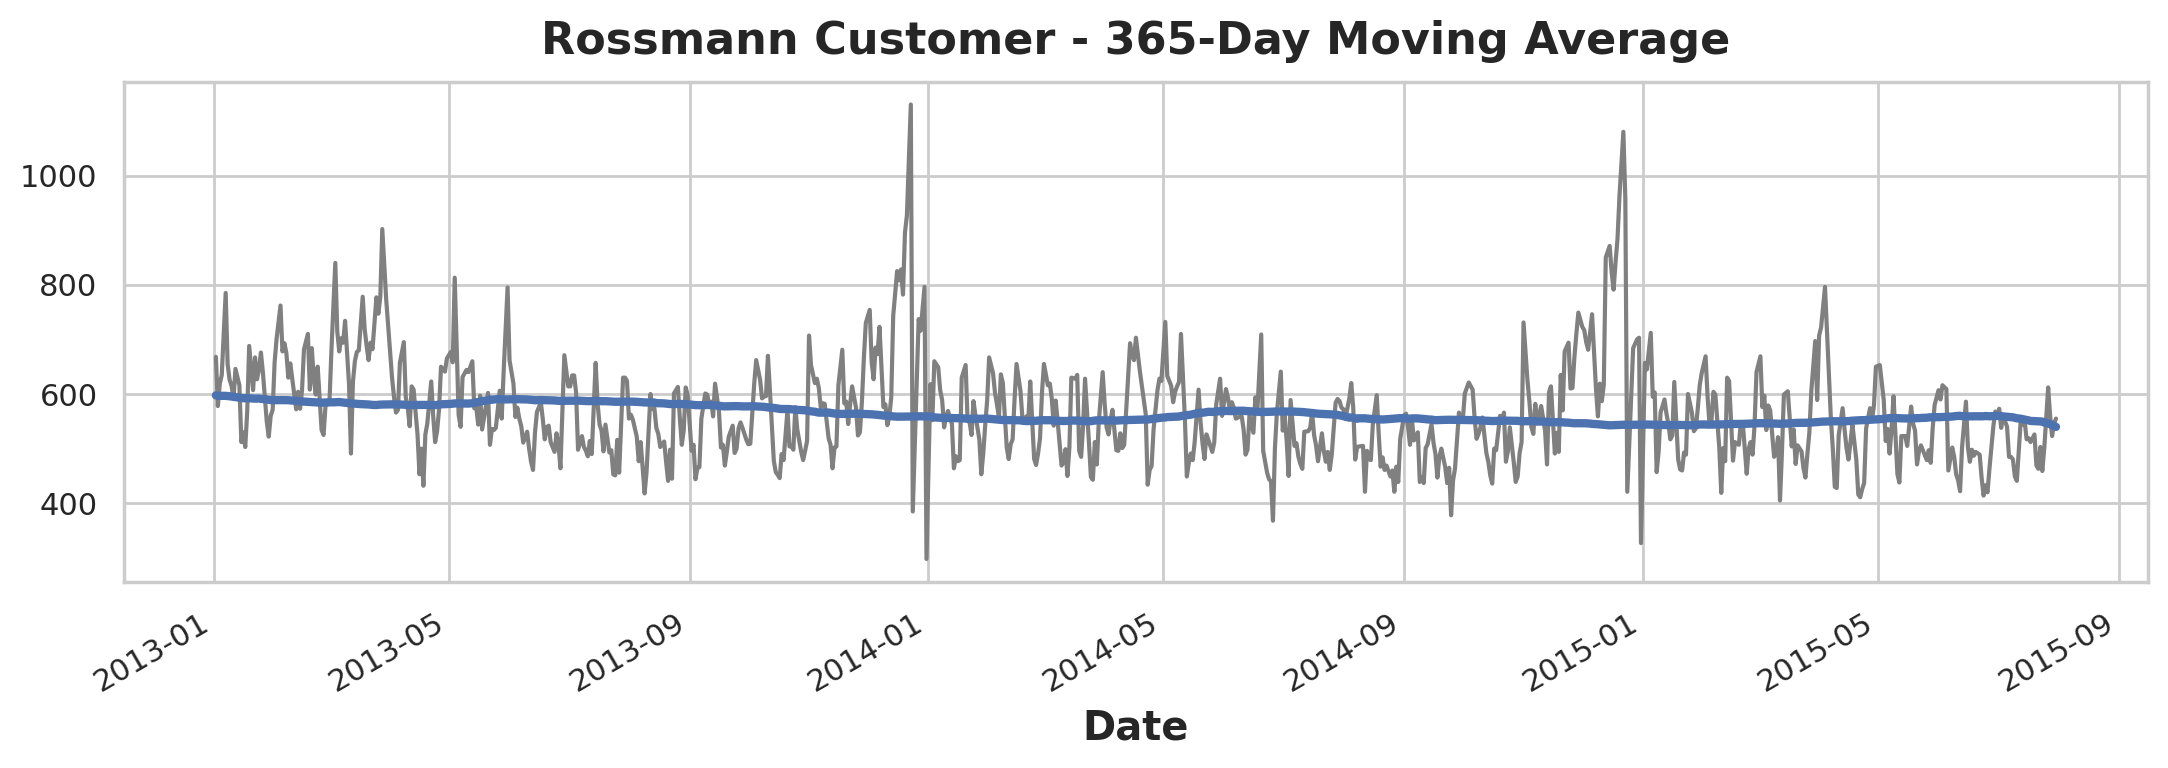

In [9]:
move_average=store1[store1['Customers']!=0]['Customers'].rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax=store1[store1['Customers']!=0]['Customers'].plot(color='0.5')
move_average.plot(ax=ax, linewidth=3, title="Rossmann Customer - 365-Day Moving Average", legend=False,);

我们发现顾客有着类似的、微小的略微下降趋势。它们都呈现出高噪声和强周期性。

###  对store1的季节性分析

/tmp/ipykernel_1685/3127732320.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/f,Pxx)


Text(0.5, 0, 'Period_for_Sales(days)')

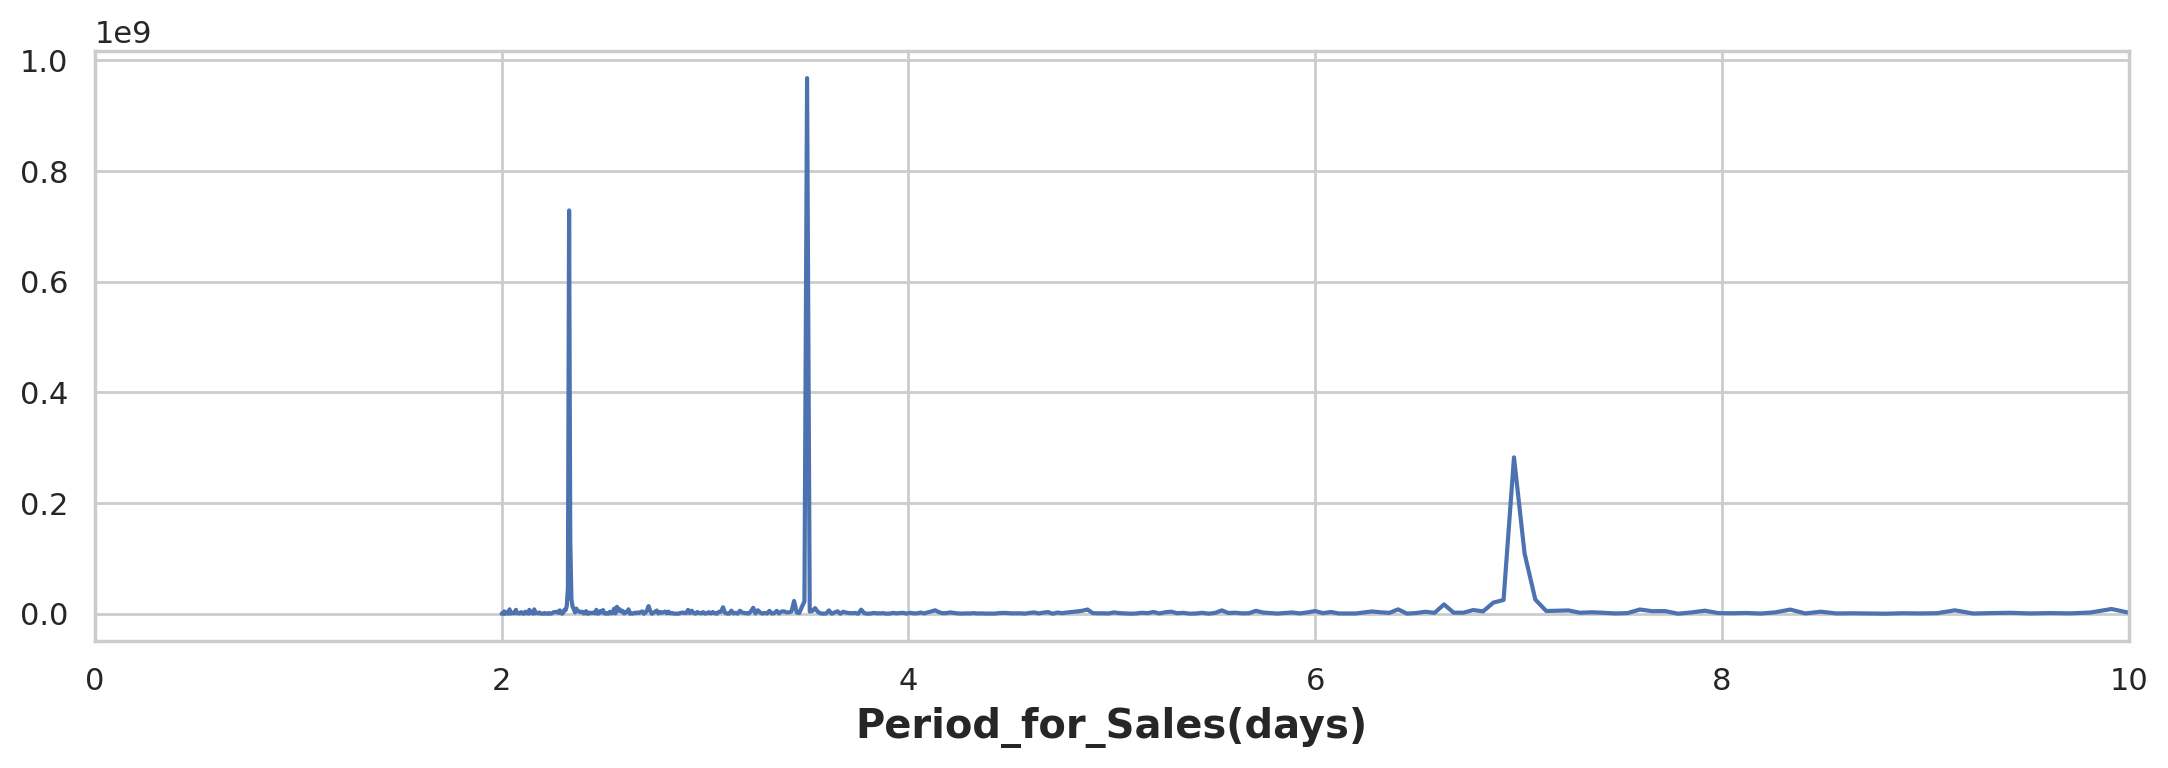

In [10]:
from scipy.signal import periodogram#用于计算周期图
f,Pxx=periodogram(store1['Sales'].asfreq('D').fillna(0))
plt.plot(1/f,Pxx)
plt.xlim(0,10)
plt.xlabel('Period_for_Sales(days)')


我们发现周期2-4天有强烈信号，7天（周级）型号相对弱很多。这可能说明工作日/周末的销售量呈现较大差异

/tmp/ipykernel_1685/3773924792.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/f2,Pxx2)


(0.0, 10.0)

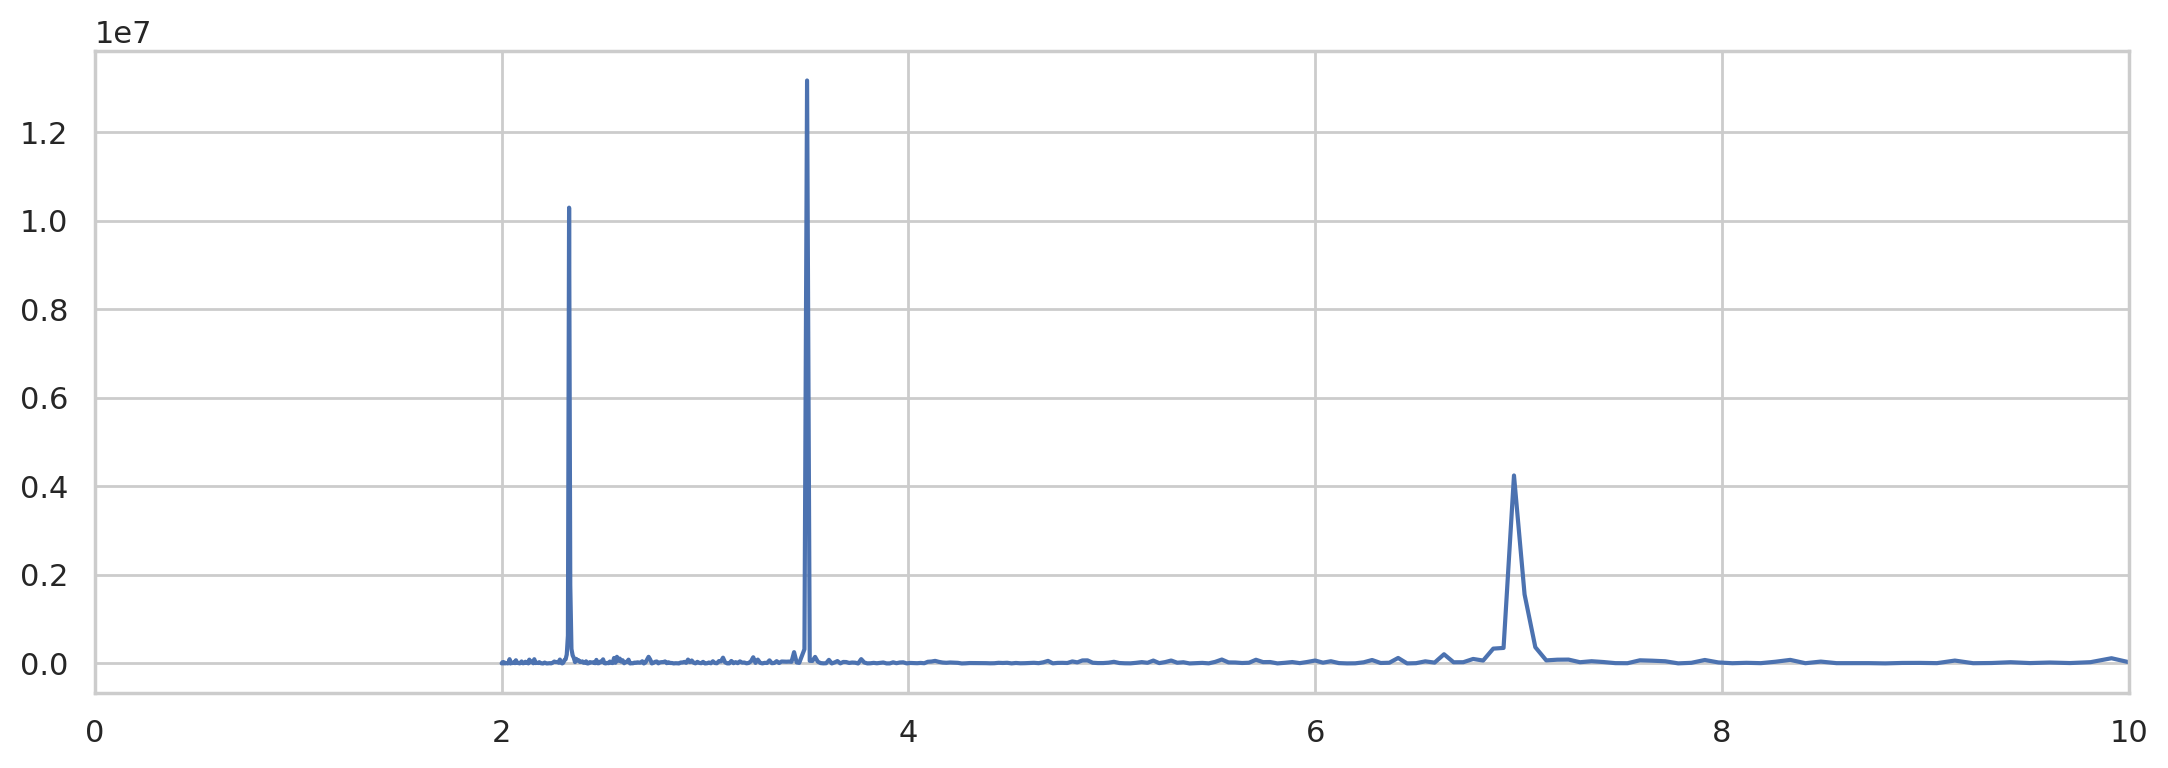

In [11]:
f2,Pxx2=periodogram(store1['Customers'].asfreq('D').fillna(0))
plt.plot(1/f2,Pxx2)
plt.xlim(0,10)

同样的，显示出同行周期

### 长期周期与adf检验

In [17]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(store1['Sales'].dropna(),
                   maxlag=None,
                   regression='c',#由于我们先前发现trend并不明显，所以采用c
                   autolag='AIC')
adf_stat, pvalue, usedlag, nobs, crit_values, icbest = results

print("ADF 统计量:", adf_stat)
print("p-value:", pvalue)
print("使用的滞后阶数:", usedlag)
print("样本数:", nobs)
print("临界值:", crit_values)  # dict: {'1%':..., '5%':..., '10%':...}
print("选出的最优信息准则值:", icbest)

ADF 统计量: -4.368104368168491
p-value: 0.00033788346141425444
使用的滞后阶数: 21
样本数: 920
临界值: {'1%': np.float64(-3.4374778690219956), '5%': np.float64(-2.864686684217556), '10%': np.float64(-2.5684454926748583)}
选出的最优信息准则值: 15667.112449225


结论：我发现ADF远小于5%临界值，且p-valuelue远小于0.05，所以拒绝单位根假设，在后续SARIMAIMA建模中，我们不需要进行差分，即d=0

我们用stl来分解长期周期

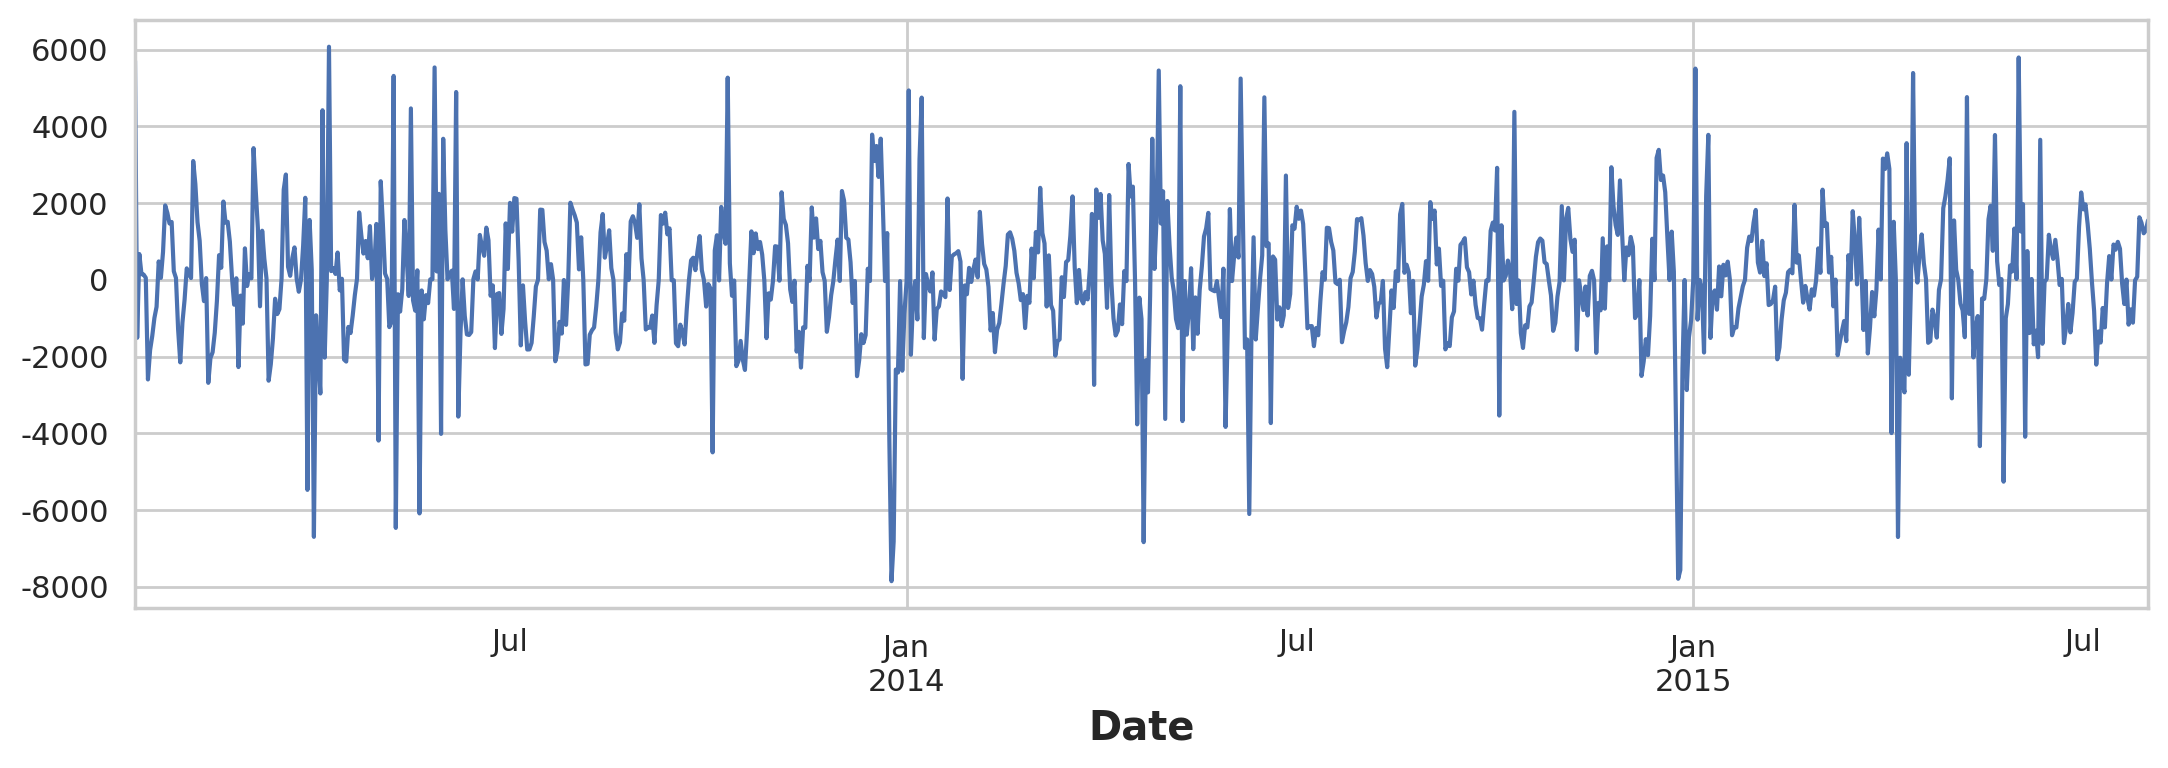

In [30]:
s=store1['Sales']-store1['Sales'].shift(7)
s=s.dropna()
stl=STL(s,period=365,robust=True)
res=stl.fit()
fig=res.seasonal.plot()
plt.show()

ACF/PACF图绘制

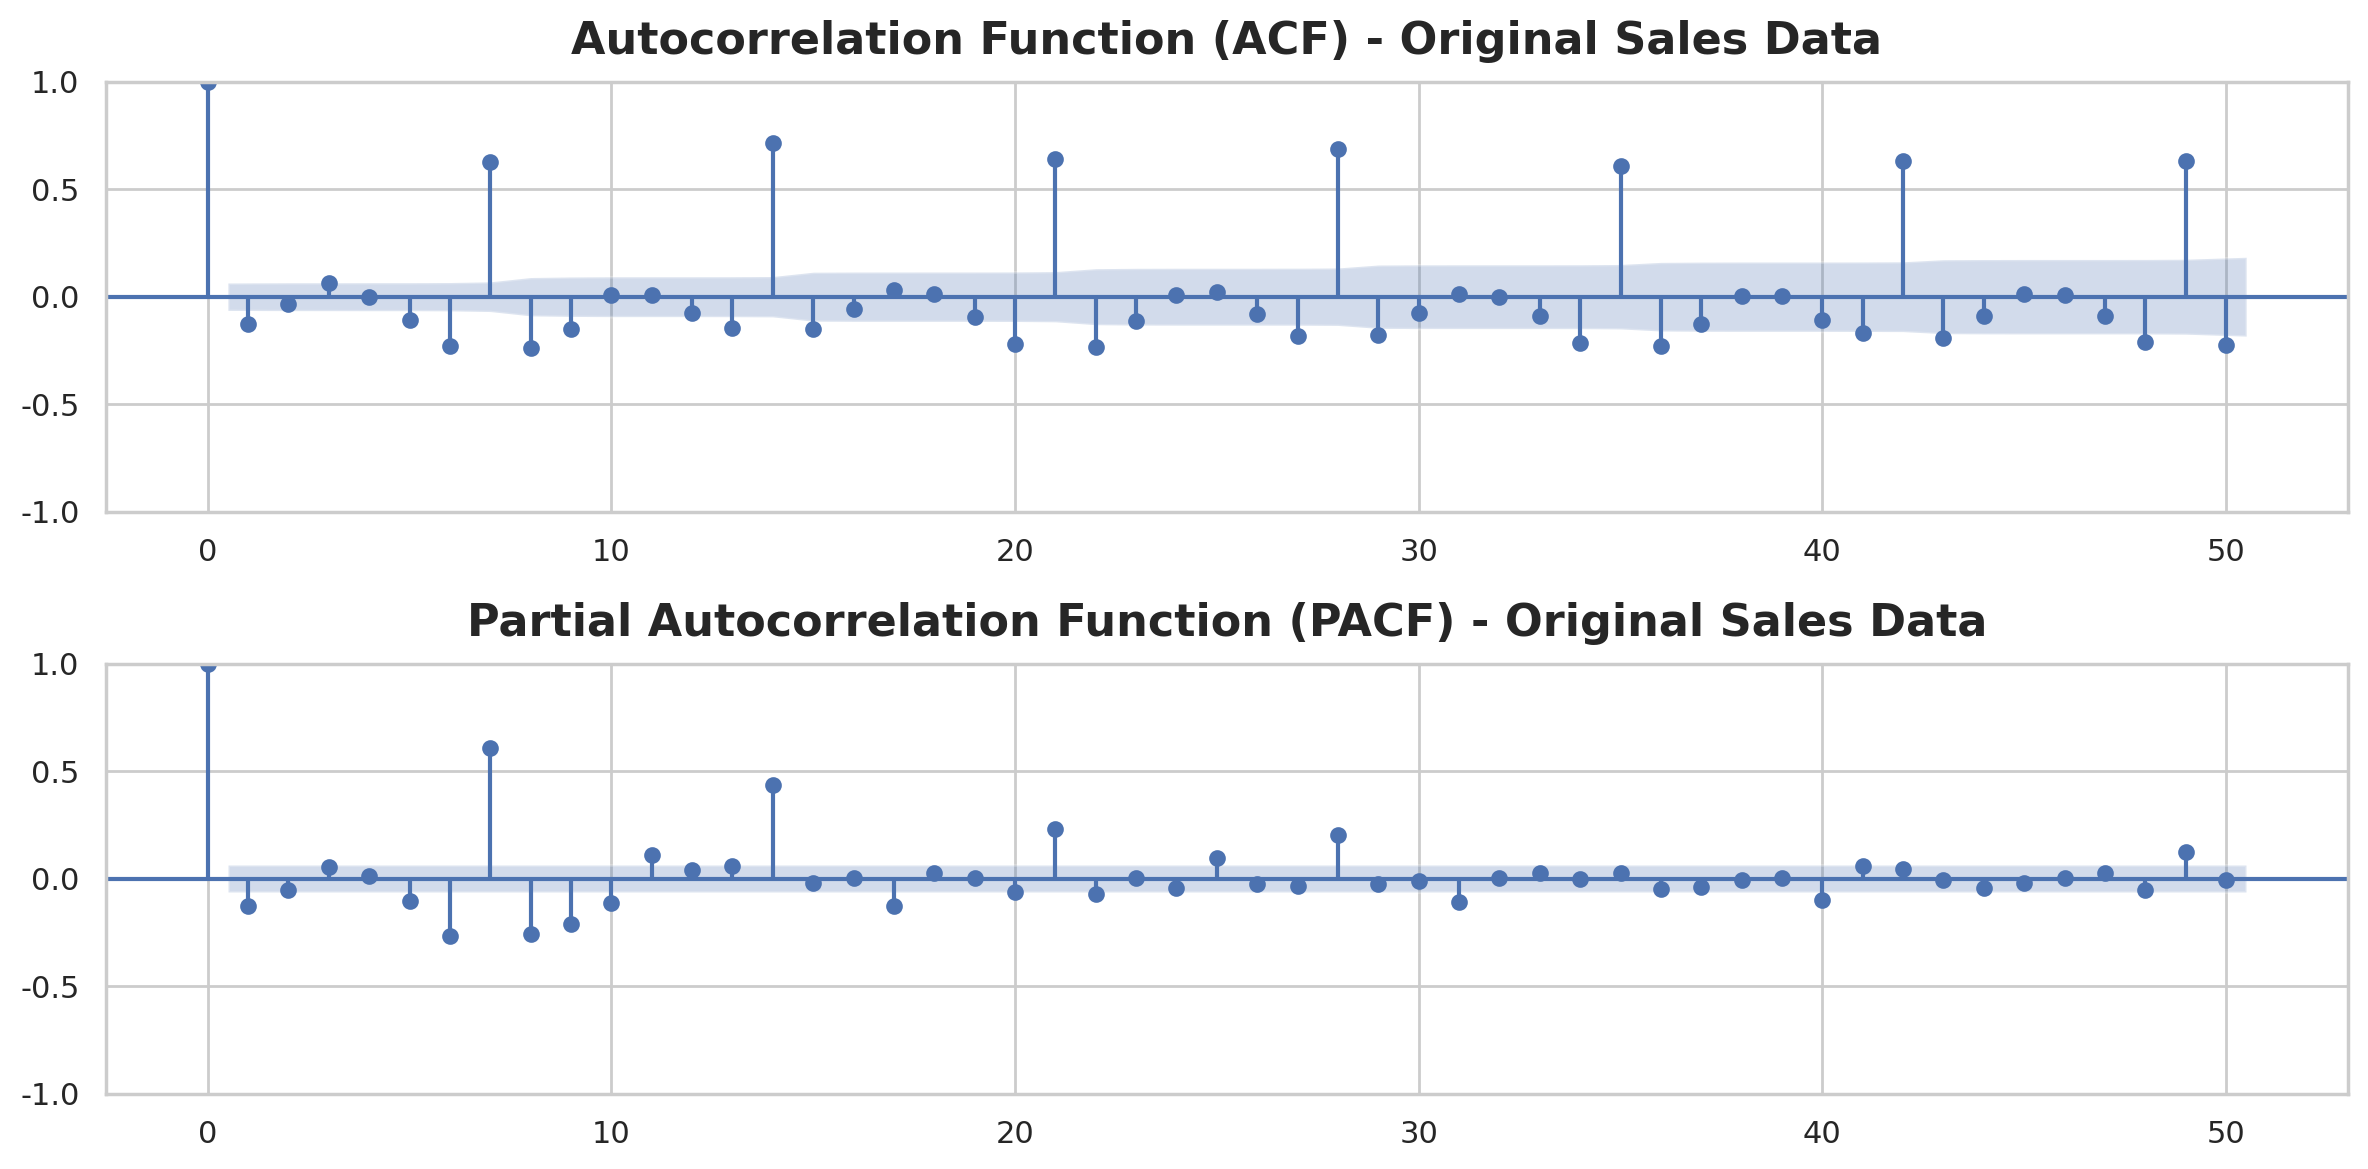

In [19]:
def plot_acf_pacf(series, lags=40, title=""):
    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(211)
    plot_acf(series.dropna(), lags=lags, ax=ax1, alpha=0.05)
    ax1.set_title(f'Autocorrelation Function (ACF) - {title}')
    ax2 = plt.subplot(212)
    plot_pacf(series.dropna(), lags=lags, ax=ax2, alpha=0.05, method='ywm')
    ax2.set_title(f'Partial Autocorrelation Function (PACF) - {title}')
    plt.tight_layout()
    plt.show()
# 对原始数据绘制 ACF 和 PACF 图
plot_acf_pacf(store1['Sales'], lags=50, title="Original Sales Data")

可以发现acf有强烈的7天周期季节性，我们做一个周差分

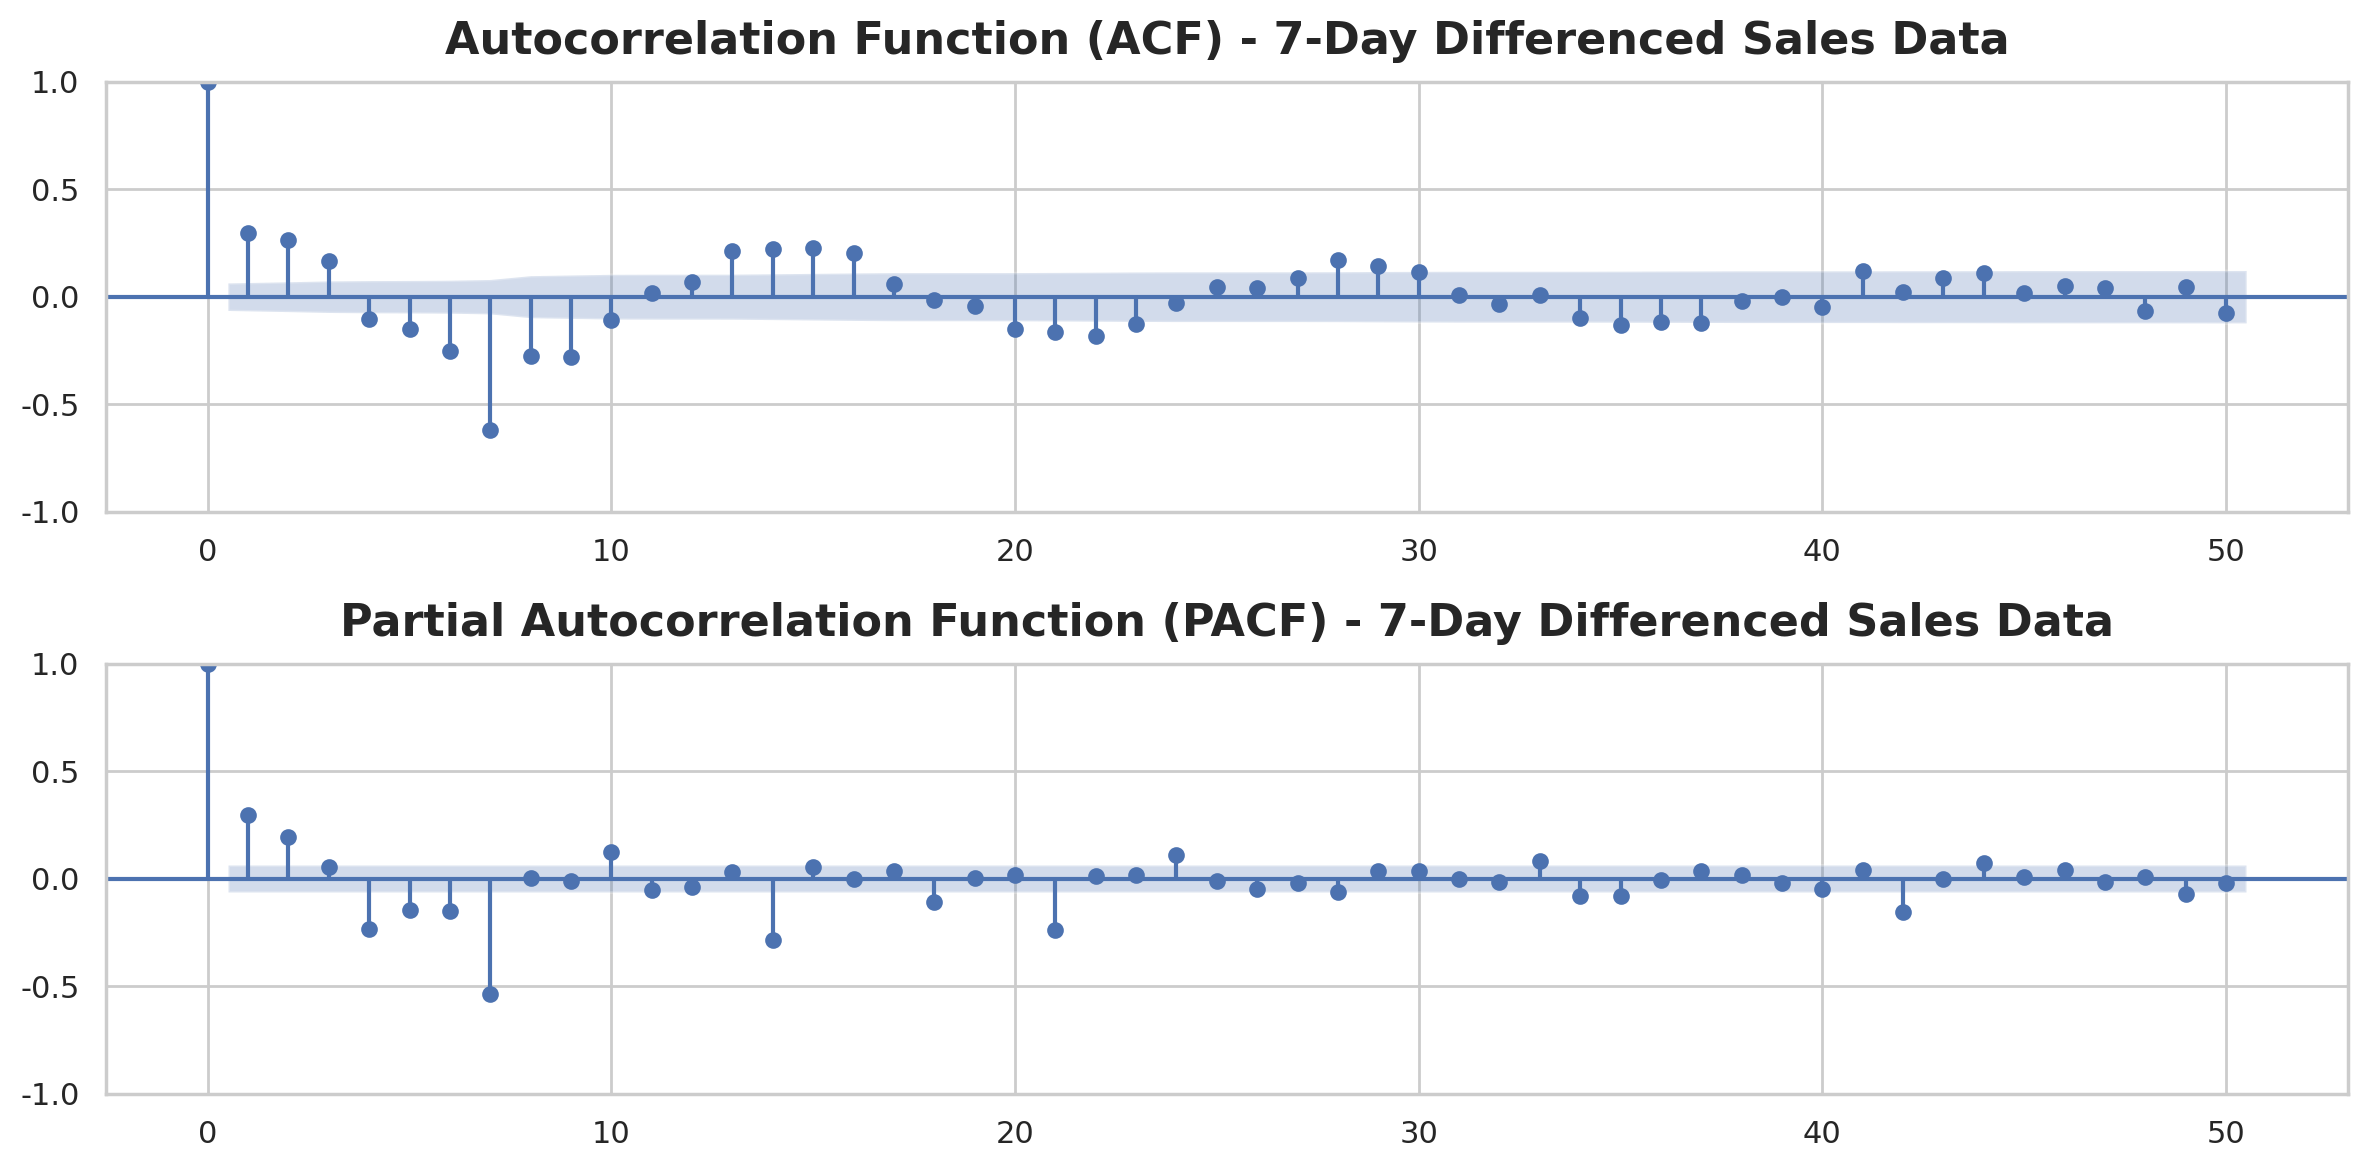

In [20]:
data_diff=store1['Sales'].diff(7).dropna()
plot_acf_pacf(data_diff, lags=50, title="7-Day Differenced Sales Data")

可以发现acf缓慢衰减35天左右，pacf截断于10天以内。预估可以使用SARIMA

In [22]:
y = (
    store1
    ["Sales"]
    .asfreq("D")              # 日频
)

# 简单补一下缺失（可以更讲究一点，这里先随便用 ffill）
y = y.fillna(method="ffill")
model = auto_arima(
    y,
    # 非季节部分 (p, d, q)
    start_p=0, start_q=0,
    max_p=3,  max_q=3,
    d=None,               # 也可以写成你自己判断的 d，比如 d=1

    # 季节部分 (P, D, Q, m)
    seasonal=True,
    m=7,                  # 一周周期
    start_P=0, start_Q=0,
    max_P=2,  max_Q=2,
    D=1,                  # 通常周季节性差一次就够了（你也可以让它 D=None 自己判）

    # 其它设置
    information_criterion="aic",  # 也可以用 bic
    trace=True,                   # 打印搜索过程，方便你看
    error_action="ignore",        # 忽略报错的组合
    suppress_warnings=True,
    stepwise=True,                # 用 stepwise 搜索，速度快很多
)

/tmp/ipykernel_1685/1094912423.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method="ffill")


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=16599.403, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=16127.685, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=16597.435, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=16510.176, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=16043.046, Time=1.25 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=15898.226, Time=1.48 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=3.50 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=15882.342, Time=1.60 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.43 sec


得到最好的SARIMA参数：ARIMA(3,0,1)(1,1,1)[7]，和我们之前观察到的周期性以及ADF平稳性一致。接下来做残差监测

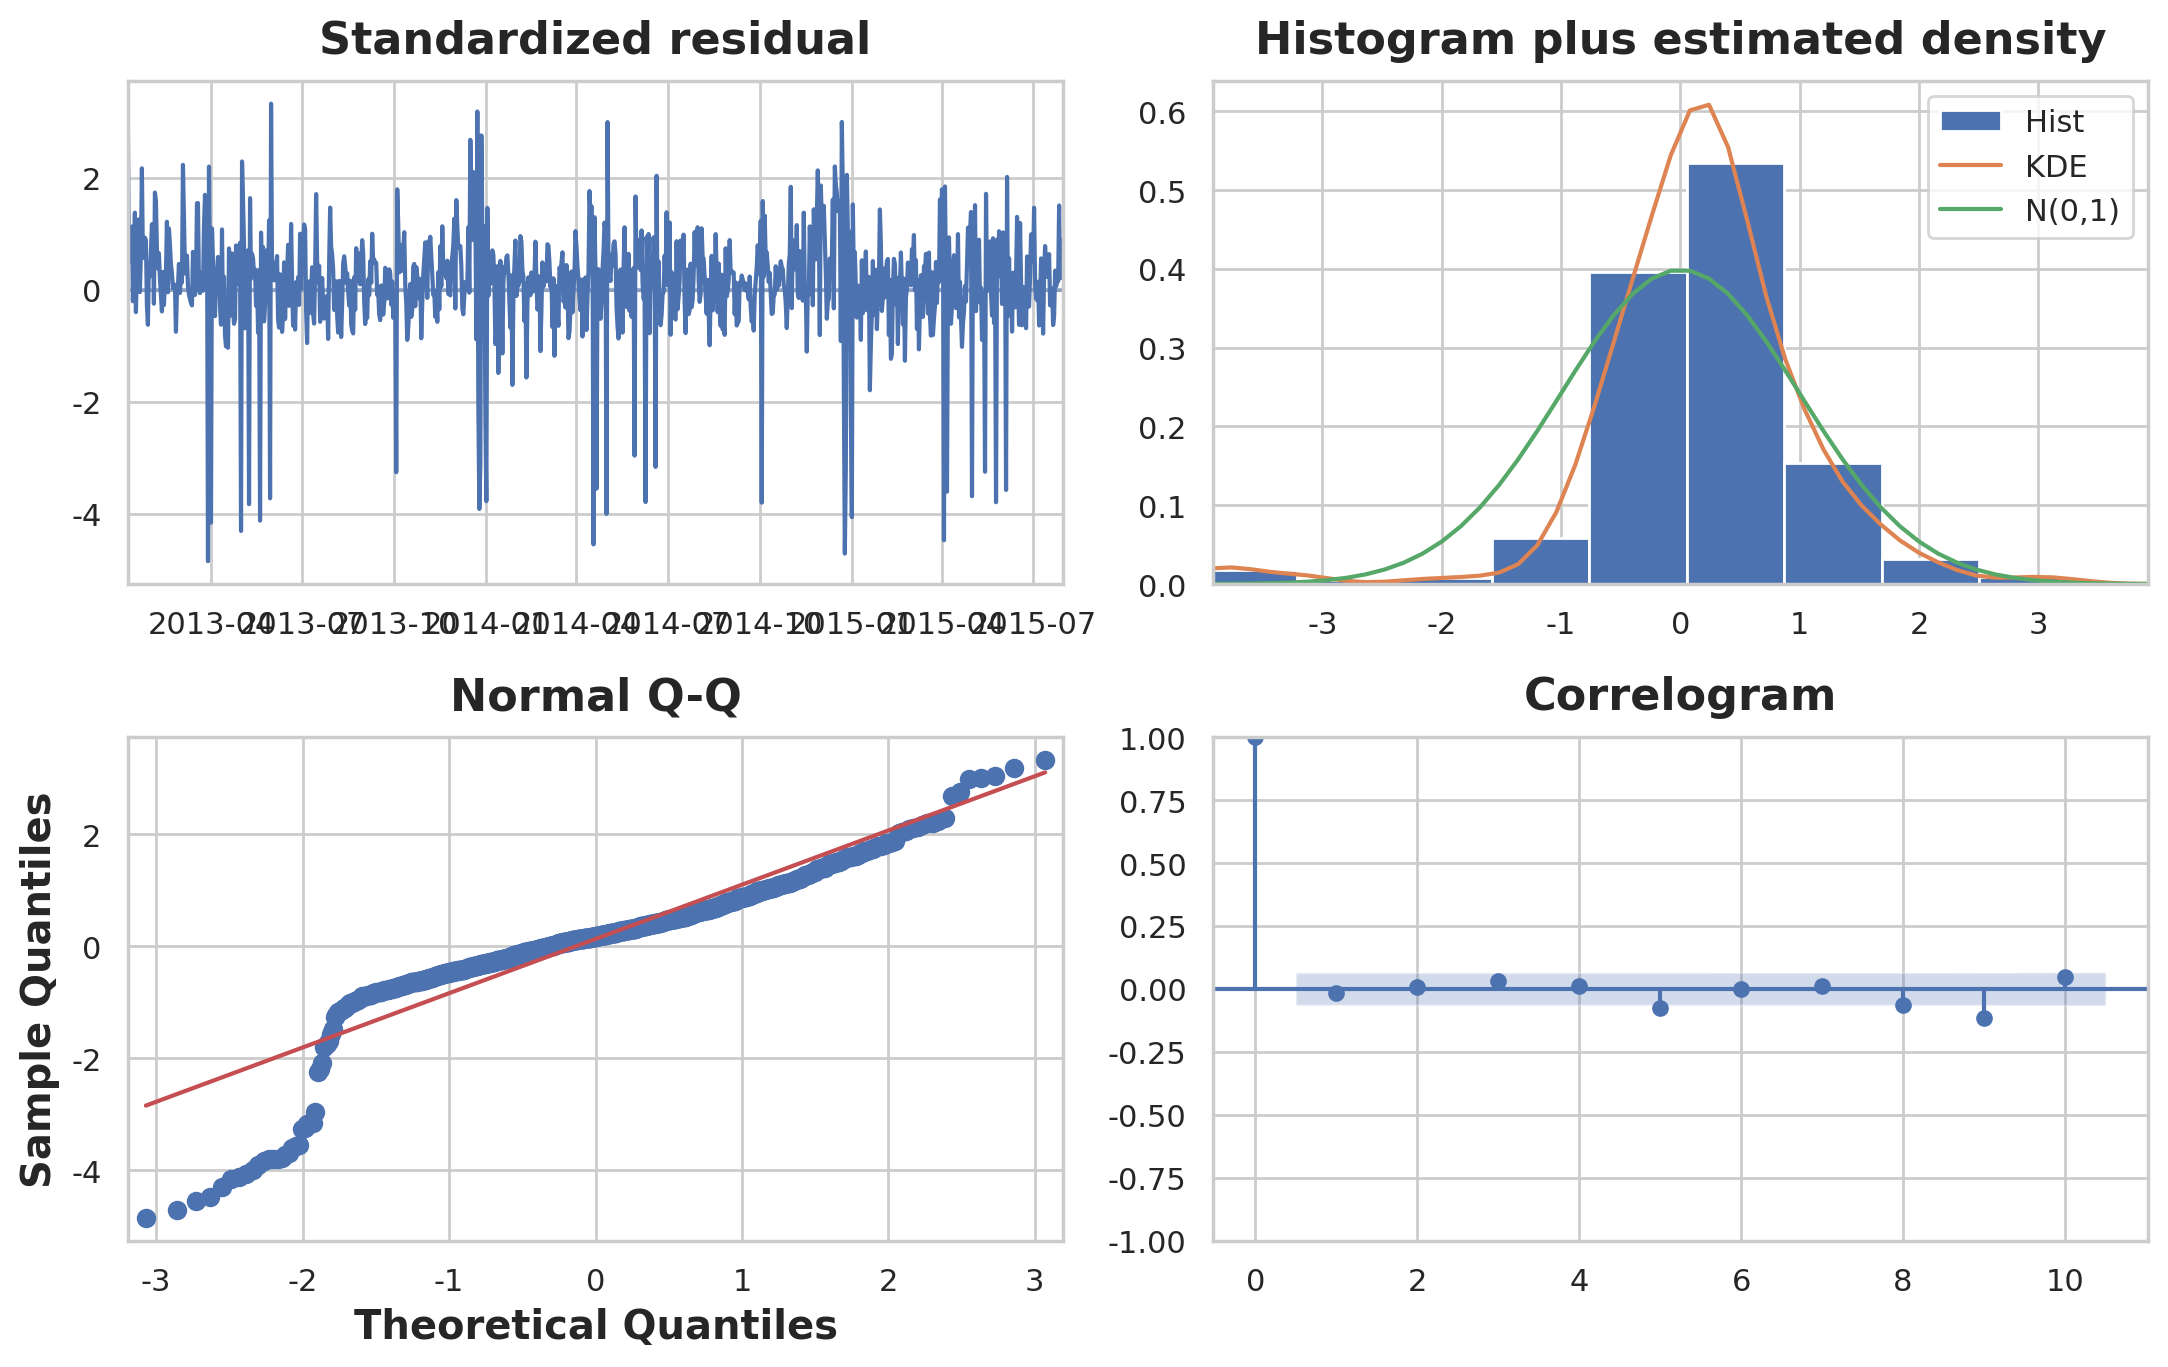

In [24]:
model.plot_diagnostics(figsize=(11, 7))
plt.show()

根据qq图，我们发现残差在中间部分拟合较好，大部分数据都集中在0附近。但有些重尾+偏态。残差的相关图除了lag=0以外基本没有值超过置信区间，残差之间几乎没有相关性，说明模型已经捕捉了大部分信息。

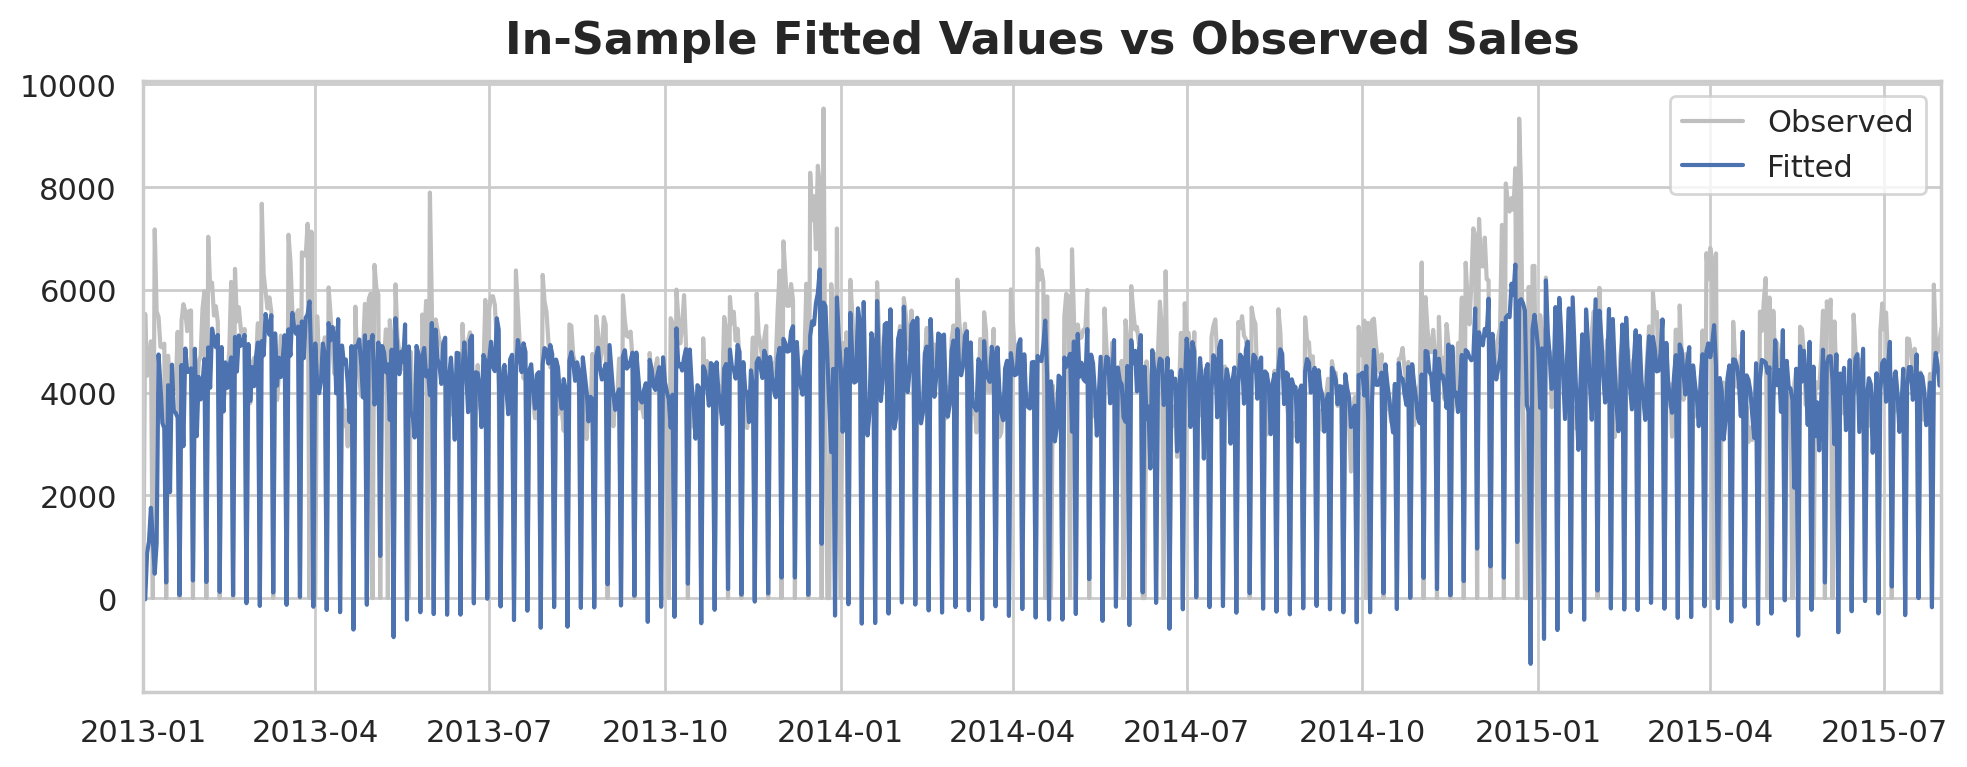

In [29]:
X=model.predict_in_sample()
plt.figure(figsize=(10, 4))
plt.plot(y, label='Observed', color='0.75')
plt.plot(X, label='Fitted', color='C0')
plt.title('In-Sample Fitted Values vs Observed Sales')
plt.xlim(y.index[0], y.index[-1])
plt.legend()

总结：通过对store1的sales和部分coustmers的分析，我们发现customers和salesles有很强的相关性，并且sales没有强烈的趋势，是一条略有下降的曲线。长期季节性不是很明显，但有非常明显的7日的周季节性，即周末的sales会明显升高。通过ADF我们发现们发现sales是平稳的，因此不需要差分。我们试图用auto-arimaima调整参数，发现符合arima(3,0,1)(1,1,1)[7]，残差时间序列无明显结构，残差 ACF 无显著自相关，Q-Q 图显示误差近似正态，因此模型在统计意义上是充分的。捕捉了短期依赖性，用于后续建模